<a href="https://colab.research.google.com/github/LiliDuenas88/MCD-AA2025/blob/master/Tarea_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 1️ Seleccionamos las variables predictoras (X) y la variable objetivo (y)
X = df[["precio_unitario", "cantidad_compra"]]   # variables independientes
y = df["stock"]                                  # variable dependiente

# 2️ Estandarizamos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3️ Aplicamos SelectKBest con la prueba F (ANOVA)
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X_scaled, y)

# 4️ Mostramos los resultados
resultados = pd.DataFrame({
    "Variable": X.columns,
    "Score": selector.scores_,
    "p-Value": selector.pvalues_
}).sort_values(by="Score", ascending=False)

print("📊 Resultados de SelectKBest:")
display(resultados)


📊 Resultados de SelectKBest:


,Variable,Score,p-Value
0,precio_unitario,12.457632,0.000442
1,cantidad_compra,8.790717,0.003123


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# --- Variables ---
X = df[["precio_unitario", "cantidad_compra"]]
y = df["stock"]

# --- Escalamos los datos ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 1) F-test (ANOVA) - Paramétrico ---
f_selector = SelectKBest(score_func=f_regression, k='all').fit(X_scaled, y)
f_scores = f_selector.scores_

# --- 2) Mutual Information - No paramétrico ---
mi_selector = SelectKBest(score_func=mutual_info_regression, k='all').fit(X_scaled, y)
mi_scores = mi_selector.scores_

# --- 3) Random Forest Importance ---
rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)
rf_importances = rf.feature_importances_

# --- 4) Lasso Regularization ---
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)
lasso_coefs = np.abs(lasso.coef_)

# --- Consolidar resultados ---
resultados = pd.DataFrame({
    "Variable": X.columns,
    "F_test": f_scores,
    "Mutual_Info": mi_scores,
    "RandomForest": rf_importances,
    "Lasso": lasso_coefs
}).set_index("Variable")

display(resultados.round(4))


,F_test,Mutual_Info,RandomForest,Lasso
Variable,,,,
precio_unitario,12.4576,3.1489,0.9963,15.9769
cantidad_compra,8.7907,1.8461,0.0037,0.0000


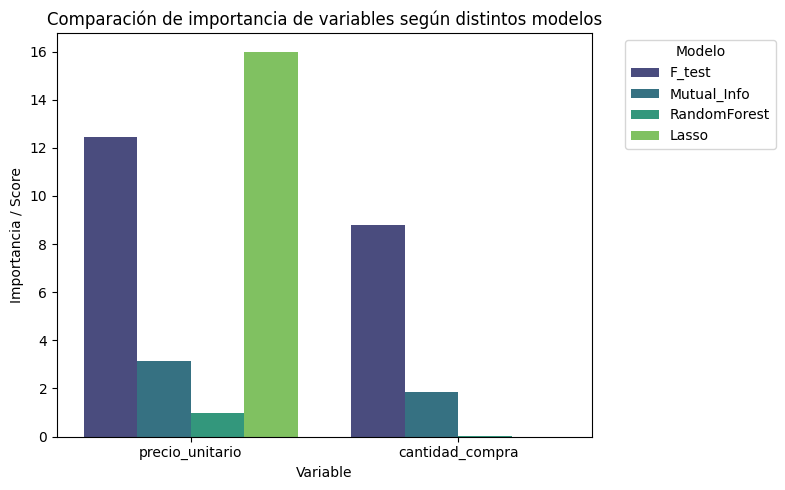

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Reorganizar para gráfico ---
resultados_plot = resultados.reset_index().melt(id_vars="Variable",
                                                var_name="Modelo",
                                                value_name="Importancia")

# --- Gráfico ---
plt.figure(figsize=(8,5))
sns.barplot(data=resultados_plot, x="Variable", y="Importancia", hue="Modelo", palette="viridis")
plt.title("Comparación de importancia de variables según distintos modelos")
plt.ylabel("Importancia / Score")
plt.xlabel("Variable")
plt.legend(title="Modelo", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [ ]:
def interpretar_resultados(resultados_df):
    texto = "=== INTERPRETACIÓN AUTOMÁTICA DE RESULTADOS ===\n\n"

    for modelo in ["F_test", "Mutual_Info", "RandomForest", "Lasso"]:
        # identificar variable con mayor score en cada modelo
        variable_top = resultados_df[modelo].idxmax()
        valor_top = round(resultados_df[modelo].max(), 4)

        texto += f"📘 En el modelo {modelo}:\n"
        texto += f"   - La variable con mayor importancia fue **{variable_top}** (score: {valor_top}).\n\n"

    # calcular la variable más frecuente como más importante
    ranking = []
    for modelo in ["F_test", "Mutual_Info", "RandomForest", "Lasso"]:
        ranking.append(resultados_df[modelo].idxmax())

    var_mas_frecuente = pd.Series(ranking).value_counts().idxmax()
    texto += "📊 Conclusión general:\n"
    texto += f"   - La variable **{var_mas_frecuente}** es la más relevante en la mayoría de los modelos.\n"
    texto += "   - Esto sugiere que es el predictor con mayor influencia sobre la variable objetivo (stock).\n\n"

    # recomendación según la variable dominante
    if var_mas_frecuente.lower().startswith("cantidad"):
        texto += "💡 Interpretación: El stock depende principalmente de la **cantidad comprada**, lo cual es lógico en un contexto comercial: a mayor cantidad vendida, menor inventario disponible."
    elif var_mas_frecuente.lower().startswith("precio"):
        texto += "💡 Interpretación: El stock está más influenciado por el **precio unitario**, indicando que los precios altos o bajos podrían afectar la rotación del inventario."
    else:
        texto += "💡 Interpretación: La variable más influyente parece tener un comportamiento importante sobre la variable objetivo."

    return texto

# Mostrar interpretación
print(interpretar_resultados(resultados))



=== INTERPRETACIÓN AUTOMÁTICA DE RESULTADOS ===

📘 En el modelo F_test:
   - La variable con mayor importancia fue **precio_unitario** (score: 12.4576).

📘 En el modelo Mutual_Info:
   - La variable con mayor importancia fue **precio_unitario** (score: 3.1489).

📘 En el modelo RandomForest:
   - La variable con mayor importancia fue **precio_unitario** (score: 0.9963).

📘 En el modelo Lasso:
   - La variable con mayor importancia fue **precio_unitario** (score: 15.9769).

📊 Conclusión general:
   - La variable **precio_unitario** es la más relevante en la mayoría de los modelos.
   - Esto sugiere que es el predictor con mayor influencia sobre la variable objetivo (stock).

💡 Interpretación: El stock está más influenciado por el **precio unitario**, indicando que los precios altos o bajos podrían afectar la rotación del inventario.



 **📚 1. Algunas métricas**

* Adjusted R² y criterios como AIC / BIC: En la revisión de métricas de selección de características se menciona que estos criterios evalúan el “ajuste del modelo” penalizado por la complejidad (número de variables) para evitar sobreajuste.

* Importancia de variables en modelos de árbol (por ejemplo el atributo feature_importances_ en scikit‑learn o la disminución de impureza en un RandomForestRegressor): Este tipo de métricas miden cuánto contribuye cada variable a las predicciones del modelo.

* Métodos de filtro (“filter methods”) como la correlación univariante, pruebas estadísticas simples, o métricas de información mutua: Por ejemplo, el módulo de feature_selection de scikit-learn describe que puedes usar tests univariados (como f-test) para seleccionar variables independientes sin usar un modelo completo.

**🔍 2. Características más relevantes del conjunto de datos**

* Variables que tengan alta correlación (o dependencia) con la variable objetivo (por ejemplo stock si se está analizando inventario, o subtotal se analiza ventas).

* Variables que no estén altamente colineales entre sí (es decir, evitar redundancia).

* Variables que aporten interpretabilidad y relevancia de negocio: en un entorno de tienda, cantidad_compra y precio_unitario tienen sentido directo — volumen vendido y precio — lo cual impacta stock, rentabilidad, etc.

**💡 Tres estudios académicos relevantes**


1.   A Novel Approach for Enhanced Feature Selection Over Retail Sales Data Using Ensemble Machine Learning Technique (2024) — Babu & Kodabagi. Usaron un conjunto POS (punto de venta) de retail para seleccionar características mediante técnicas de ensemble (Random Forest, Gradient Boosting, etc.).
ResearchGate.

Este estudio adopta un enfoque de selección de características optimizado para ventas minoristas, lo que respalda la selección de variables clave en mi análisis.

2.   Analysis of Sales Influencing Factors and Prediction of Sales in Supermarket Based on Machine Learning Technique (2018) — Yang & Ramingwong. Analizó un conjunto de datos de supermercado, usó correlación + Random Forest para identificar qué variables afectan las ventas, y reportó importancia de características como “unit price” y “quantity”.
datascience.cmu.ac.th

En este otro estudio, la cantidad y el precio unitario figuraron como factores relevantes, lo que refuerza mi elección de estas variables.

3.   Nonparametric Feature Impact and Importance (2020) — Parr, Wilson & Hamrick. Desarrollo teórico sobre cómo medir la “importancia de características” en métodos no paramétricos, y alerta sobre no confundir “importancia” con “impacto real”.

Dado que mis variables no siguen distribución normal, me respaldo en esta investigación que explica la importancia de usar métricas no paramétricas para selección de características.

**📚 Referencias bibliográficas**

1. Babu, S. S., & Kodabagi, M. M. (2024).
A novel approach for enhanced feature selection over retail sales data using ensemble machine learning technique.
ResearchGate. https://www.researchgate.net/publication/380293286_A_Novel_Approach_for_Enhanced_Feature_Selection_Over_Retails_Sales_Data_Using_Ensemble_Machine_Learning_Technique

2. Yang, S., & Ramingwong, S. (2018).
Analysis of sales influencing factors and prediction of sales in supermarket based on machine learning technique.
Chiang Mai University Journal of Data Science.
https://datascience.cmu.ac.th/storage/articles/32.pdf


